In [17]:
import numpy as np # linear algebra
import pandas as pd
from sklearn.metrics import *
from PIL import Image
from io import BytesIO
import requests

import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim 
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

## Loading MNIST Datasets

In [18]:
data = pd.read_csv("../input/mnist_train.csv")
X,Y = data.values[:,1:]/255,data.values[:,0]
X = torch.from_numpy(X).cuda().view(-1,1,28,28)
Y = torch.from_numpy(Y).cuda()

In [19]:
data = pd.read_csv("../input/mnist_test.csv")
Xtest,Ytest = data.values[:,1:]/255,data.values[:,0]
Xtest = torch.from_numpy(Xtest).cuda().view(-1,1,28,28)
Ytest = torch.from_numpy(Ytest).cuda()

## Defining Model

In [20]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, 1)
        self.conv2 = nn.Conv2d(16, 32, 5, 1)
        self.fc1 = nn.Linear(4*4*32, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
model = LeNet().cuda().double()
opt = optim.Adam(model.parameters(),lr=.001)
crit = nn.CrossEntropyLoss()
BATCH_SIZE = 100

## Training Model On MNIST

In [21]:
%%time
avg = []
XX = X.view(-1,1,28,28)
for i in range(6000):
    inp_idx = torch.randperm(len(X))[:BATCH_SIZE]
    XB = XX[inp_idx]
    YB = Y[inp_idx]
    
    opt.zero_grad()
    yp = model(XB)
    loss = crit(yp,YB)
    loss.backward()
    opt.step()
    
    avg.append(loss.item())
    if i%600==0:
        #lr.step()
        print(i//600,sum(avg)/len(avg))
        avg = []

2.307180868719391
0.2110788662174578
0.054730024550552835
0.037487882714976384
0.02891206935187366
0.023571701847878206
0.019413354362172973
0.014183513840542311
0.0132074079262653
0.01153803698715851
CPU times: user 26.5 s, sys: 1.08 s, total: 27.6 s
Wall time: 27.7 s


## Prediction on Test Set

In [22]:
start = 0
outs = []
while start<len(Xtest):
    XB = Xtest[start:start+200]
    with torch.no_grad():
        outs.append(model(XB))
    start += 200
YP = torch.cat(outs,dim=0)
yp = torch.argmax(YP,dim=1)
'Test Accuarcy:',(Ytest==yp).sum().item()/len(Ytest)*100

('Test Accuarcy:', 99.02)

## Adversarial Attack on Trained Model

### Original Image and Its Probabilities 

9

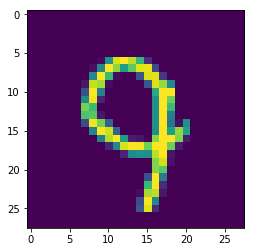

In [68]:
idx = 999
plt.imshow(Xtest[idx].cpu().numpy().transpose(1,2,0).reshape(28,28));Ytest[idx].item()

In [69]:
y = model(Xtest[idx].unsqueeze(0)).detach()
y,torch.argmax(y)

(tensor([[ -5.7139, -14.3993,  -7.0456,  -4.2681,   0.4198,  -7.7548, -17.7839,
            4.0600,  -2.7391,  16.1106]], device='cuda:0', dtype=torch.float64),
 tensor(9, device='cuda:0'))

## Carlini & Wagner ATTACK

In [77]:
x = Xtest[idx].clone()
x.requires_grad_(True)
with torch.no_grad():
    logits = model(x.unsqueeze(0)).squeeze()
    IMX = torch.argmax(logits)
print("Init idx:",IMX.item())
    
lr=.01
while True:
    logits = model(x.unsqueeze(0)).squeeze()
    
    imx = torch.argmax(logits)
    if imx!=IMX: 
        print("Job done, breaking")
        break
    y = logits.clone()
    y[imx] = -99
    loss = logits.max() - y.max() 
    loss.backward()
    
    
    x.data.sub_(lr*x.grad.data)
    print(loss.item(),logits.max().item(), y.max().item() )
    print()
    x.grad.data.zero_()
    x.data.sub_(x.data.min())
    x.data.mul_(1/x.data.max())
    
with torch.no_grad():
    print(model(x.unsqueeze(0)).squeeze())

Init idx: 9
12.050555281958133 16.110596200638383 4.060040918680252

9.773259283530436 14.768800721725315 4.995541438194879

7.424705019709302 13.261571057800262 5.83686603809096

5.111557752516618 11.771185177004352 6.659627424487733

2.388815787711441 10.036394104133647 7.647578316422206

Job done, breaking
tensor([ -5.2594,  -7.7334,  -2.5260,  -2.1191,  -0.8115,  -8.0947, -15.7488,
          8.8177,  -2.6991,   8.1364], device='cuda:0', dtype=torch.float64)


### Modified Image and New prediction

7

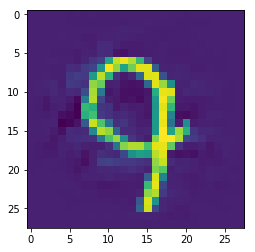

In [74]:
plt.imshow(x.detach().cpu().numpy().transpose(1,2,0).reshape(28,28));torch.argmax(model(x.unsqueeze(0))).item()


## FGSM ATTACK

In [75]:
x = Xtest[idx].clone()
x.requires_grad_(True)
with torch.no_grad():
    logits = model(x.unsqueeze(0)).squeeze()
    IMX = torch.argmax(logits)
print("Init idx:",IMX.item())


logits = model(x.unsqueeze(0))
loss = F.cross_entropy(logits,Ytest[idx].unsqueeze(0))
loss.backward()
x = x + .06 * torch.sign(x.grad.data)
with torch.no_grad():
    logits = model(x.unsqueeze(0)).squeeze()
    print(logits,torch.argmax(logits))

Init idx: 9
tensor([ -5.8075,  -9.0186,  -2.3979,  -2.8104,  -1.3040,  -9.8661, -17.5590,
          9.8514,  -2.5267,   9.5589], device='cuda:0', dtype=torch.float64) tensor(7, device='cuda:0')


### Modified Image and New prediction

7

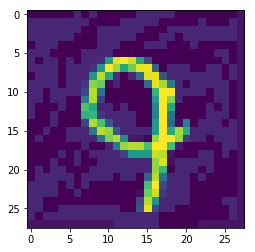

In [76]:
plt.imshow(x.detach().cpu().numpy().transpose(1,2,0).reshape(28,28));torch.argmax(model(x.unsqueeze(0))).item()


### New erroneous Prediction

tensor(7, device='cuda:0')